In [1]:
import re
import six
import math
import lmdb
import os
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.display import display

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

import keras_ocr

# 데이터셋 준비

In [2]:
BATCH_SIZE = 128
DATA_DIR = './data'

# MJ 데이터셋 위치
TRAIN_DATA_PATH = os.path.join(DATA_DIR, 'MJ/MJ_train')
VALID_DATA_PATH = os.path.join(DATA_DIR, 'MJ/MJ_valid')
TEST_DATA_PATH = os.path.join(DATA_DIR, 'MJ/MJ_test')

━━━━━━━━ 1 ━━━━━━━━
original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


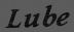

━━━━━━━━ 2 ━━━━━━━━
original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


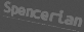

━━━━━━━━ 3 ━━━━━━━━
original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


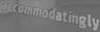

━━━━━━━━ 4 ━━━━━━━━
original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


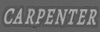

In [3]:
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

with env.begin(write=False) as txn:
    for index in range(1, 5):
        print(f"━━━━━━━━ {index} ━━━━━━━━")
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                dataset_path,
                label_converter,
                batch_size=1,
                img_size=(100,32),
                max_text_len=22,
                is_train=False,
                character='') :
        
        self.label_converter = label_converter  # 문자를 미리 정의된 index로 변환해주는 converter
        self.batch_size = batch_size  # 배치 사이즈
        self.img_size = img_size  # 입력 이미지 크기
        self.max_text_len = max_text_len  # 최대 글자 수
        self.character = character  # 학습 대상으로 한정하기 위한 character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다

    # - 이미지 데이터를 img, label 의 쌍으로 가져오는 메서드
    # => 다양한 사이즈의 이미지를 모두 height 는 32, width 는 최대 100 이 되도록 가공
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__

    # - model.fit() 에서 호출되는 메서드: 배치 단위만큼 _get_img_label()을 통해 가져온 데이터셋 리턴
    def __getitem__(self, idx):
        # 1. idx에 해당하는 index_list만큼 데이터를 불러
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2. image와 label을 불러오고 
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

class LabelConverter(object):

    # 입력으로 받은 text를 self.dict 에 각 character 들이 어떤 index 에 매핑되는지 저장
    # => character, index 를 통해 모델이 학습할 수 있는 output 이 생성됨
    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    # character -> index 변환
    # cf. 공백 문자를 뜻하는 '-' 의 label 은 0 으로 지정
    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    # 같은 문자 사이에 공백(blank) 문자 label을 삽입
            encoded_label.append(self.label_map[char])

        return np.array(encoded_label)

    # index -> character 변환
    # => 사람이 읽을 수 있는 text 로 변경
    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

In [4]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")  # 36

The total number of characters is 36


In [5]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encoded_text = label_converter.encode('HELLO')
print("Encoded_text: ", encoded_text)  # [ 8  5 12  0 12 15]
decoded_text = label_converter.decode(encoded_text)
print("Decoded_text: ", decoded_text)  # HEL-LO
# 동일한 글자가 연속될 때는, 그 사이에 '-'가 포함되게 되어있다.

Encoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


In [6]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

print(f'Train DataSet 개수: {len(train_set)}')  # 565
print(f'Valid DataSet 개수: {len(val_set)}')  # 63
print(f'Test DataSet 개수: {len(test_set)}')  # 70

Train DataSet 개수: 565
Valid DataSet 개수: 63
Test DataSet 개수: 70


## 모델 학습

In [7]:
def ctc_lambda_func(args):
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    # Conv Layers
    # Feature 추출
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)

    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)

    # Recurrent Layers
    # 추출된 Feature 의 전체적인 Context 파악
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)

    # Transcription Layer(=Fully Connected Layer)
    # Step 마다 어떤 Character 의 확률이 높은지 예측
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    # CRNN 모델 생성
    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(inputs=model_input, outputs=loss_out)
    return model


In [8]:
model = build_crnn_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 100, 32, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 32, 64)  1792        input_image[0][0]                
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 50, 16, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 16, 128)  73856       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1, clipnorm=5)
model.compile(
    optimizer=optimizer,
    loss={'ctc': lambda y_true, y_pred: y_pred},
    metrics=['accuracy'],
)
EPOCHS=50

ckp = tf.keras.callbacks.ModelCheckpoint(
    f'model_checkpoint_{EPOCHS}.hdf5', monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min'
)
crnn_history = model.fit(
    train_set,
    steps_per_epoch=len(train_set),
    epochs=EPOCHS,
    validation_data=val_set,
    validation_steps=len(val_set),
    callbacks=[ckp, earlystop]
)


Epoch 1/50
565/565 [==============================] - 97s 151ms/step - loss: 25.2523 - accuracy: 0.0000e+00 - val_loss: 24.9061 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 24.90611, saving model to model_checkpoint_50.hdf5
Epoch 2/50
565/565 [==============================] - 84s 149ms/step - loss: 13.4889 - accuracy: 0.0044 - val_loss: 8.5787 - val_accuracy: 0.0265

Epoch 00002: val_loss improved from 24.90611 to 8.57867, saving model to model_checkpoint_50.hdf5
Epoch 3/50
565/565 [==============================] - 85s 151ms/step - loss: 6.6488 - accuracy: 0.1113 - val_loss: 6.3943 - val_accuracy: 0.1672

Epoch 00003: val_loss improved from 8.57867 to 6.39429, saving model to model_checkpoint_50.hdf5
Epoch 4/50
565/565 [==============================] - 85s 151ms/step - loss: 4.8637 - accuracy: 0.2730 - val_loss: 5.1803 - val_accuracy: 0.2896

Epoch 00004: val_loss improved from 6.39429 to 5.18026, saving model to model_checkpoint_50.hdf5
Epoch 5/50
565/565 

In [12]:
def draw_history(history, model_name='Recognition_CRNN'):
    plt.subplots(figsize=(12,4))

    # Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # Model Accuracy, Validation Accuracy 시각화
    plt.subplot(122)
    plt.plot(history.history['accuracy'], 'r')
    plt.plot(history.history['val_accuracy'], 'b')
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

    plt.tight_layout()
    plt.savefig(f'{model_name}_Result.png')  # 저장
    plt.show()

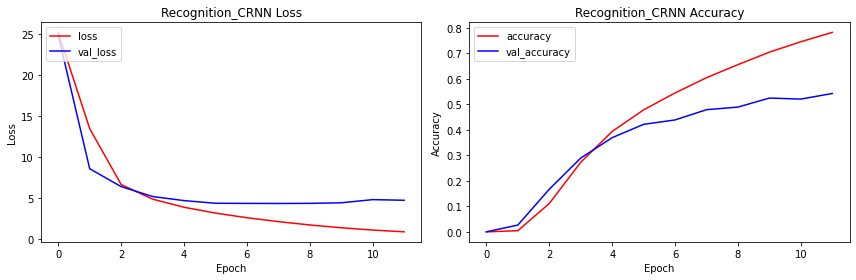

In [13]:
draw_history(crnn_history, 'Recognition_CRNN')

In [14]:
model = build_crnn_model()
model.load_weights(f'model_checkpoint_{EPOCHS}.hdf5')

## 인퍼런스 모델 생성.

In [16]:
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

## 인퍼런스 결과 확인


In [17]:
# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        # 의미없는 인덱스 -1 위치 숫자 9 출력 방지
        if index == -1:
            continue
        # 예측한 문자 저장
        text += chars[index]
    return text

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        print(f"━━━━━━━━ {i} ━━━━━━━━")
        inputs, outputs = dataset[i]
        img = inputs['input_image'][0:1,:,:,:]
        output = model.predict(img)  # 모델 예측

        # 예측
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS).replace('-','')
        print(f"Result: \t{result}")
        
        # 라벨
        label = ''.join(map(lambda x: label_converter.decode(x), inputs['label'][0:1,])).replace('-','')
        print(f"Label:  \t{label}")

        # 예측, 라벨 인덱스별로 비교해서 같으면 1, 다르면 0 표시
        is_right = ''.join(map(lambda x: '1' if x[0] == x[1] else '0', zip(result, label)))
        print(f"Is_Right:\t{is_right}")

        # 맞춘 문자 개수, 점수 계산
        is_right_count = is_right.count('1')
        print(f"Is_Right_Count:\t{is_right_count}/{len(label)}")
        print(f"Score: {is_right_count/len(label):.2f}")

        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

━━━━━━━━ 0 ━━━━━━━━
Result: 	SLINKING
Label:  	SLINKING
Is_Right:	11111111
Is_Right_Count:	8/8
Score: 1.00


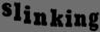

━━━━━━━━ 1 ━━━━━━━━
Result: 	ALEPPO
Label:  	ALEPPO
Is_Right:	111111
Is_Right_Count:	6/6
Score: 1.00


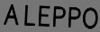

━━━━━━━━ 2 ━━━━━━━━
Result: 	IRWANDA
Label:  	RWANDA
Is_Right:	000000
Is_Right_Count:	0/6
Score: 0.00


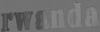

━━━━━━━━ 3 ━━━━━━━━
Result: 	NATHANS
Label:  	NATHANS
Is_Right:	1111111
Is_Right_Count:	7/7
Score: 1.00


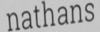

━━━━━━━━ 4 ━━━━━━━━
Result: 	HALBO
Label:  	HALLOO
Is_Right:	11101
Is_Right_Count:	4/6
Score: 0.67


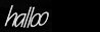

━━━━━━━━ 5 ━━━━━━━━
Result: 	HURLS
Label:  	HURLS
Is_Right:	11111
Is_Right_Count:	5/5
Score: 1.00


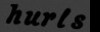

━━━━━━━━ 6 ━━━━━━━━
Result: 	DOWNSIZE
Label:  	DOWNSIZE
Is_Right:	11111111
Is_Right_Count:	8/8
Score: 1.00


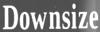

━━━━━━━━ 7 ━━━━━━━━
Result: 	ROBOTIC
Label:  	ROBOTIC
Is_Right:	1111111
Is_Right_Count:	7/7
Score: 1.00


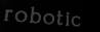

━━━━━━━━ 8 ━━━━━━━━
Result: 	SLOPPY
Label:  	SLOPPY
Is_Right:	111111
Is_Right_Count:	6/6
Score: 1.00


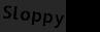

━━━━━━━━ 9 ━━━━━━━━
Result: 	HERMITE
Label:  	HERMITE
Is_Right:	1111111
Is_Right_Count:	7/7
Score: 1.00


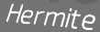

━━━━━━━━ 10 ━━━━━━━━
Result: 	DEARS
Label:  	DEARS
Is_Right:	11111
Is_Right_Count:	5/5
Score: 1.00


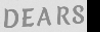

━━━━━━━━ 11 ━━━━━━━━
Result: 	POLYSYLABIL
Label:  	POLYSYLLABIC
Is_Right:	11111110000
Is_Right_Count:	7/12
Score: 0.58


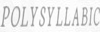

━━━━━━━━ 12 ━━━━━━━━
Result: 	DEE
Label:  	DENSE
Is_Right:	110
Is_Right_Count:	2/5
Score: 0.40


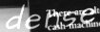

━━━━━━━━ 13 ━━━━━━━━
Result: 	DIAERESES
Label:  	DIAERESES
Is_Right:	111111111
Is_Right_Count:	9/9
Score: 1.00


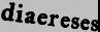

━━━━━━━━ 14 ━━━━━━━━
Result: 	FBUMPBACKS
Label:  	HUMPBACKS
Is_Right:	000000000
Is_Right_Count:	0/9
Score: 0.00


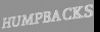

━━━━━━━━ 15 ━━━━━━━━
Result: 	ADOPTEDI
Label:  	ADOPTED
Is_Right:	1111111
Is_Right_Count:	7/7
Score: 1.00


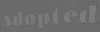

━━━━━━━━ 16 ━━━━━━━━
Result: 	NIWAUKEE
Label:  	MILWAUKEE
Is_Right:	01000001
Is_Right_Count:	2/9
Score: 0.22


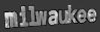

━━━━━━━━ 17 ━━━━━━━━
Result: 	SPECIFICATION
Label:  	SPECIFICATION
Is_Right:	1111111111111
Is_Right_Count:	13/13
Score: 1.00


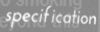

━━━━━━━━ 18 ━━━━━━━━
Result: 	REACTIONARY
Label:  	REACTIONARY
Is_Right:	11111111111
Is_Right_Count:	11/11
Score: 1.00


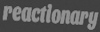

━━━━━━━━ 19 ━━━━━━━━
Result: 	OSCEOLA
Label:  	OSCEOLA
Is_Right:	1111111
Is_Right_Count:	7/7
Score: 1.00


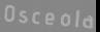

In [18]:
check_inference(model_pred, test_set, index=20)

## Keras OCR detector 사용

In [20]:
def detect_text(img_path, detector):
    
    # 이미지 불러오기
    img_pil = Image.open(img_path).convert('RGB')  # (1200, 900, 3)

    # 1. Keras-OCR 의 Detection 모델에 입력하기 위한 이미지 전처리
    # - 이미지 비율 유지해서 resize() 적용
    # - 배치 크기 때문에 4 dims 로 확장
    # - shape=(H,W,C) 여야 모델 입력시 제대로 동작함
    width, height = img_pil.size  # 원본 이미지 크기
    target_width = min(int(width*300/height), 400)  # 이미지 비율 유지, 높이 300, 너비는 400 보다 작게 설정
    target_img_size = (target_width,300)

    img_pil = img_pil.resize(target_img_size)  # (400, 300, 3)
    img_pil_copy = img_pil.copy()

    img_pil = np.array(img_pil)  # (300, 400, 3)
    img_pil = np.expand_dims(img_pil, axis=0)  # (1, 300, 400, 3)
    
    # 2. 모델 예측
    # - OCR 텍스트 검출 결과
    # - 배치 첫 번째 결과 가져오기
    detect_result = detector.detect(img_pil)  # 타입: list
    ocr_result = detect_result[0]  # 타입: np.array
	
    # 3. display() 하기 위한 이미지 전처리
    # - 앞서 4 dims 로 확장시켰으므로 다시 3 dims 가 되도록 축소
    # - shape=(H,W,C) 여야 display() 에서 이미지가 제대로 그려짐
    img_pil = np.squeeze(img_pil, axis=0).astype(np.uint8)  # (300, 400, 3)
    img_pil = Image.fromarray(img_pil)
    img_draw = ImageDraw.Draw(img_pil)

    cropped_imgs = []  # 단어 영역
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil_copy.crop(word_box))
    
    return img_pil, cropped_imgs

def recognize_img(idx, pil_img, model_pred, input_img_size=(100,32)):
    # CRNN 기반의 Recognition 모델에 입력하기 위한 이미지 전처리
    # - 배치 크기 때문에 4 dims 로 확장
    # - shape=(W,H,C) 여야 모델 입력시 제대로 동작함
    pil_img = pil_img.resize(input_img_size)  # (100, 32, 3)
    pil_img = np.array(pil_img)  # (32, 100, 3)
    pil_img = pil_img.transpose(1,0,2)  # (100, 32, 3)
    pil_img = np.expand_dims(pil_img, axis=0)  # (1, 100, 32, 3)
    
    # 모델 예측
    # - OCR 텍스트 인식 결과 출력
    output = model_pred.predict(pil_img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS).replace('-','')
    print("Result: \t", result)
    
    # display() 하기 위한 이미지 전처리
    # - 앞서 4 dims 로 확장시켰으므로 다시 3 dims 가 되도록 축소
    # - shape=(H,W,C) 여야 display() 에서 이미지가 제대로 그려짐
    pil_img = np.squeeze(pil_img, axis=0).transpose(1,0,2).astype(np.uint8)  # (32, 100, 3)
    pil_img = Image.fromarray(pil_img)
    pil_img.save(f'result/Text_Recognition_{idx}.png')  # 저장
    display(pil_img)
    
def end_to_end_ocr(img_path, detector, model_pred):
    # Text Detection
    print('━━━━━━━━ Text Detection ━━━━━━━━')
    img_pil, cropped_img = detect_text(img_path, detector)
    img_pil.save(f'result/sample.png')  # 저장
    display(img_pil)

    # Text Recognition
    print('━━━━━━━━ Text Recognition ━━━━━━━━')
    for idx, _img in enumerate(cropped_img):
        recognize_img(idx, _img, model_pred)


Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
━━━━━━━━ Text Detection ━━━━━━━━


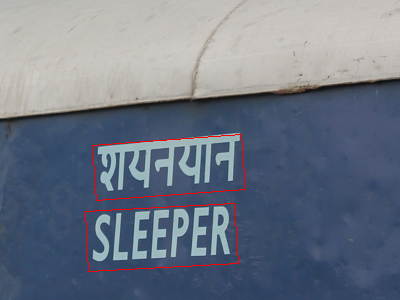

━━━━━━━━ Text Recognition ━━━━━━━━
Result: 	 TAGRIFT


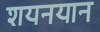

Result: 	 SLEEPER


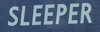

In [22]:
detector = keras_ocr.detection.Detector()
end_to_end_ocr('./data/sample.jpg', detector, model_pred)